In [94]:
from mundilib import MundiCatalogue
from utils import height2width
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Init wms
c = MundiCatalogue()
wms = c.get_collection("Sentinel2").mundi_wms('L2A')


In [95]:
legend_data = [[0, [0, 0, 0], 'No Data', 0],
              [1, [1, 0, 0.016], 'Saturated / Defective', 2],
              [2, [0.525, 0.525, 0.525], 'Dark Area', 2],
              [3, [0.467, 0.298, 0.043], 'Cloud shadows', 2],
              [4, [0.063, 0.827, 0.176], 'Vegetation', 2],
              [5, [1, 1, 0.325], 'Bare soil', 1],
              [6, [0, 0, 1], 'Water', 0],
              [7, [0.506, 0.506, 0.506], 'Clouds low probability / Unclassified', 2],
              [8, [0.753, 0.753, 0.753], 'Clouds medium probability', 2],
              [9, [0.949, 0.949, 0.949], 'Clouds high probability', 2],
              [10, [0.733, 0.773, 0.925], 'Cirrus', 3],
              [11, [0.325, 1, 0.980], 'Snow / Ice', 5]]
              
danger_zones = [[[[21.082764,56.532513],[21.094437,56.521435],[21.115379,56.525696],[21.118813,56.545479],[21.09478,56.54671],[21.082764,56.532513]], 'Gruti parvarams purvs', 0]]


In [96]:
_projection_ = 'EPSG:4326'
_bbox_       = (20.955391,56.452436, 21.225929,56.565158)
_time_       = '2023-03-03'
_height_     = 512
_width_      = height2width(_bbox_, _height_)

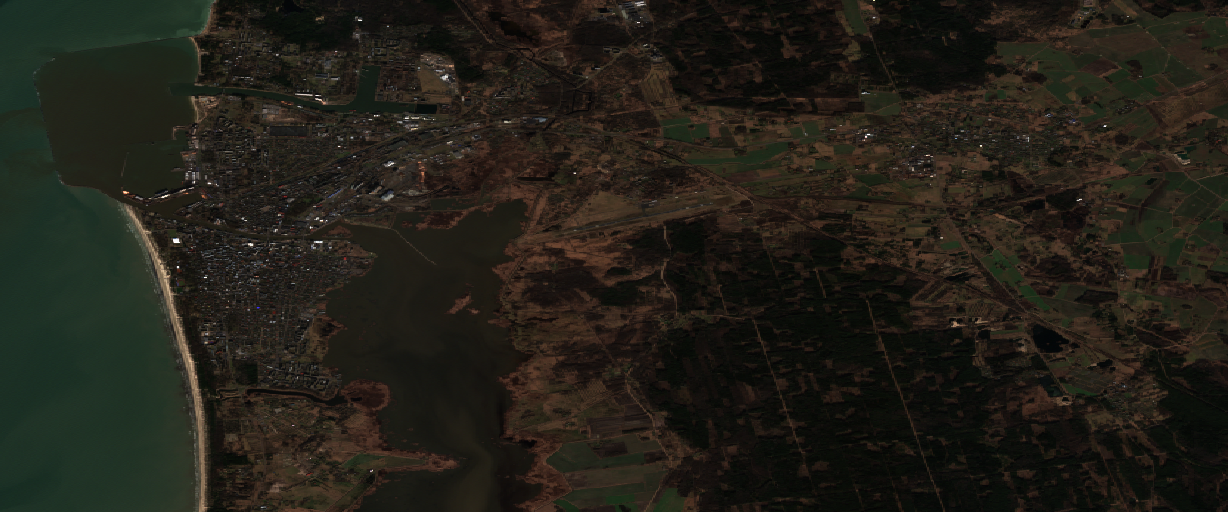

In [97]:
img_tc = wms.getmap(layers=['TRUE_COLOR'],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)

display(Image.open(img_tc))


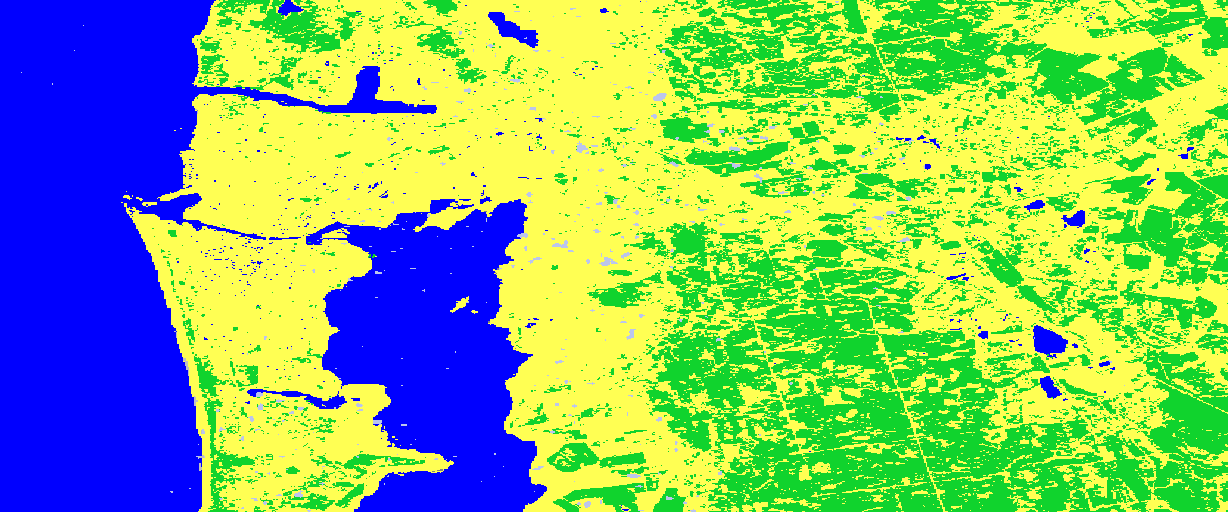

In [98]:
img_scl = wms.getmap(layers=['SCL'],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)

display(Image.open(img_scl))

In [99]:
pip install pathfinding shapely geopy

Note: you may need to restart the kernel to use updated packages.


In [100]:
img_scl_raw = wms.getmap(layers=['SCL_GRAYSCALE'],
                     srs=_projection_,
                     bbox=_bbox_,
                     size=(_width_, _height_),
                     format='image/tiff',
                     time=_time_,
                     showlogo=False,
                     transparent=False)

In [101]:
scaling = ((_bbox_[2] - _bbox_[0]) / _width_, (_bbox_[3] - _bbox_[1]) / _height_)

print(scaling)

(0.00022030781758957814, 0.00022016015624999608)


In [109]:
for zone in danger_zones:
    polygon_coords = np.empty_like(zone[0])
    polygon_coords[:] = zone[0]
    for b in range(len(polygon_coords)):
        polygon_coords[b][0], polygon_coords[b][1] = coords_to_xy(polygon_coords[b][0], polygon_coords[b][1])

    polygon = Polygon(polygon_coords)
    
    print(polygon.is_valid)
    print(polygon.area)

True
13466.737661154903


In [116]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import math

def coords_to_xy(lat, lon):
    x = (lat - _bbox_[0]) / scaling[0]
    y = (_bbox_[3] - lon) / scaling[1]
    return x, y


def find_path(scl_img, x1, y1, x2, y2):
    writable_array = scl_img.copy()
    x1, y1 = coords_to_xy(x1, y1)
    x2, y2 = coords_to_xy(x2, y2)
    
    # find weights
    for i in range(len(writable_array[:,0])):
        for a in range(len(writable_array[0,:])):
            mobility = int(scl_img[i, a]/23)
            writable_array[i, a] = legend_data[mobility][3]
            
            # Check polygons
            for zone in danger_zones:
                polygon_coords = np.empty_like(zone[0])
                polygon_coords[:] = zone[0]
                for b in range(len(polygon_coords)):
                    polygon_coords[b][0], polygon_coords[b][1] = coords_to_xy(polygon_coords[b][0], polygon_coords[b][1])
                
                polygon = Polygon(polygon_coords)
                point = Point(a, i)
                
                if polygon.contains(point):
                    writable_array[i, a] = zone[2]
                
            
    grid = Grid(matrix=writable_array)
    start = grid.node(int(x1), int(y1))
    end = grid.node(int(x2), int(y2))
    
    finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
    path, runs = finder.find_path(start, end, grid)
    
    print('operations:', runs, 'path length:', len(path))
    return path


def draw_path(img, path, size=0):
    writable_array = img.copy()
    for point in path:
        if size == 0:
            writable_array[point[1], point[0]] = [255, 0, 0]
        else:
            x_min = point[0] - size
            x_max = point[0] + size
            y_min = point[1] - size
            y_max = point[1] + size
            writable_array[y_min:y_max, x_min:x_max] = [255, 0, 0]
        
    # draw polygons
    for zone in danger_zones:
        polygon_coords = np.empty_like(zone[0])
        polygon_coords[:] = zone[0]
            
        for a in range(len(polygon_coords)):
            x1, y1 = coords_to_xy(polygon_coords[a][0], polygon_coords[a][1])
            x2, y2 = coords_to_xy(polygon_coords[(a+1)%len(polygon_coords)][0], polygon_coords[(a+1)%len(polygon_coords)][1])

            x_length = abs(x2 - x1)
            y_length = abs(y2 - y1)
            
            length = math.sqrt(x_length**2 + y_length**2)
            
            if x1 < x2:
                x_inc = x_length / length
            else:
                x_inc = -x_length / length
                
            if y1 < y2:
                y_inc = y_length / length
            else:
                y_inc = -y_length / length
                
            draw_x = x1
            draw_y = y1
            for i in range(int(length)):
                writable_array[int(draw_y), int(draw_x)] = [0, 0, 255]
                draw_x = draw_x + x_inc
                draw_y = draw_y + y_inc
        
        
    display(Image.fromarray(writable_array))

In [111]:
# {"type":"Polygon","coordinates":[[[21.004829,56.50306],[21.012383,56.504766],[21.005859,56.507607],[21.004829,56.50306]]]}
# {"type":"Polygon","coordinates":[[[21.144218,56.532797],[21.151085,56.534122],[21.144218,56.537151],[21.144218,56.532797]]]}

path = find_path(np.asarray(Image.open(img_scl_raw)), 21.004829, 56.50306, 21.144218,56.532797)

operations: 31740 path length: 636


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


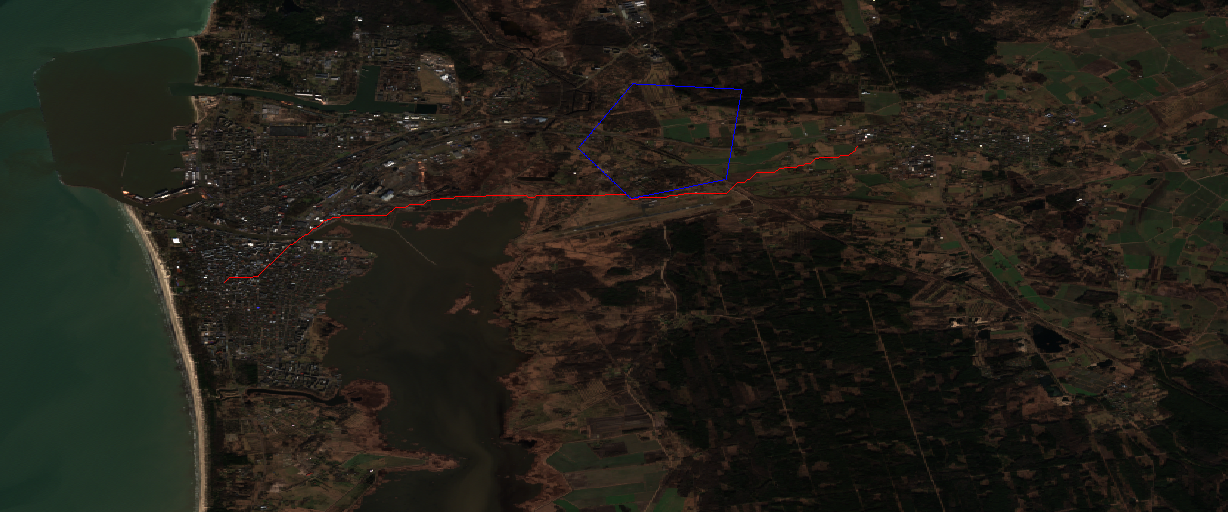

In [117]:
array = np.asarray(Image.open(img_tc))

draw_path(np.delete(array, 3, 2), path, 0)